# TM10007 Assignment head and neck 
Group 12:
Milou ter Braak (4560132), Joris Behr (4670043), Bram Schalkwijk (4856228)

## Importing packages and data

In [1]:
!pip install -q --upgrade git+https://github.com/karinvangarderen/tm10007_project.git # Comment when using google colab

### Import packages

In [12]:
from load_data import load_data # Comment when using google colab
# from hn.load_data import load_data # Comment when using visual studio code

import seaborn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.svm import SVC

pd.options.mode.chained_assignment = None  # Disabling 'chained' warning

### Self defined functions

In [13]:
def binner(y, class1):
    '''
    Transform y_label to binary
    '''
    y_bin = []
    for val in y:
        if val == class1:
            y_bin.append(0)
        else:
            y_bin.append(1) 
    return y_bin
def plot_roc(y_score, y_truth, output_dir, title):
    '''
    Plot an ROC curve.
    '''
    # Only take scores for class = 1
    y_score = y_score[:, 1]
    
    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = metrics.roc_curve(y_truth, y_score)
    roc_auc = metrics.auc(fpr, tpr)     
    
    # Plot the ROC curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    # plt.savefig(output_dir) # Comment when using google colab
    plt.show() # Comment when using visual studio code
def eval_func(features, label):
    '''
    Entire script for evaluation set up, without random_state.
    Note: Same code as in next sections!
    '''
    X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=.2, stratify=label)
    
    y_train_bin = binner(y_train, 'T12') # make binary y_score
    y_test_bin = binner(y_test, 'T12')

# Outlier detection
    for feature in X_train.columns:
        Q1 = np.percentile(X_train[feature], 25, interpolation = 'midpoint') # Defining quartiles
        Q3 = np.percentile(X_train[feature], 75, interpolation = 'midpoint')
        IQR = Q3 - Q1
        if not IQR == 0: # If 0, all values in range, so no adjusting necessary
            X_train.loc[X_train[feature] > (Q3+1.5*IQR),feature] = Q3 # Upper bound
            X_train.loc[X_train[feature] < (Q1-1.5*IQR),feature] = Q1 # Lower bound

    for feature in X_test.columns:
        Q1 = np.percentile(X_test[feature], 25, interpolation = 'midpoint')
        Q3 = np.percentile(X_test[feature], 75, interpolation = 'midpoint')
        IQR = Q3 - Q1
        if not IQR == 0:
            X_test.loc[X_test[feature] > (Q3+1.5*IQR),feature] = Q3 
            X_test.loc[X_test[feature] < (Q1-1.5*IQR),feature] = Q1

    # Scaler
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    X_train_scaled = pd.DataFrame(X_train_scaled, columns = features.columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns = features.columns)

    coefs = []
    accuracies = []
    times = []
    n_alphas = 100
    alphas = np.logspace(-7, -1, n_alphas)

    for a in alphas:
        # Fit classifier
        clf = Lasso(alpha=a, fit_intercept=False,tol=0.044) # tol set to avoid warnings
        clf.fit(X_train_scaled, y_train_bin) 
        y_pred = clf.predict(X_test_scaled)
        
        # Append statistics
        accuracy = clf.score(X_train_scaled,y_train_bin)
        accuracies.append(accuracy)
        coefs.append(clf.coef_)

    selector = SelectFromModel(estimator=Lasso(alpha=10**(-6), tol=0.002248888888888889), threshold='median')
    selector.fit(X_train_scaled, y_train_bin)
    n_original = X_train_scaled.shape[1]
    X_train_fs = selector.transform(X_train_scaled)
    X_test_fs = selector.transform(X_test_scaled)
    n_selected = X_train_fs.shape[1]

    N_COMP = .9 # Capture components at 90% of the variance
    pca = PCA(n_components=N_COMP)
    pca.fit(X_train_fs)
    X_train_pca = pca.transform(X_train_fs)
    X_test_pca = pca.transform(X_test_fs)

    # SVC
    # Create a 6 fold stratified CV iterator
    cv_6fold = StratifiedKFold(n_splits=6)
    results = []
    best_cls = []
    y_train_a = y_train.to_numpy()

    # Loop over the folds
    for train_opt_index, validation_index in cv_6fold.split(X_train_pca,y_train_a):
        # Split the data properly
        X_train_opt = X_train_pca[train_opt_index]
        y_train_opt = y_train_a[train_opt_index]
        
        X_validation = X_train_pca[validation_index]
        y_validation = y_train_a[validation_index]
        
        # Create a grid search to find the optimal k using a gridsearch and 3-fold cross validation
        # Same as above
        parameters = {
            'C':list(np.linspace(0.01,1,100)),
        }
        svm_clf = SVC(kernel = 'linear', probability=True)
        cv_3fold = StratifiedKFold(n_splits=3)
        grid_search = GridSearchCV(svm_clf, parameters, cv=cv_3fold, scoring='roc_auc')
        grid_search.fit(X_train_opt, y_train_opt)
        
        # Get resulting classifier
        clf = grid_search.best_estimator_

        best_cls.append(clf.C)
        
        # Test the classifier on the train_opt data
        probabilities_train_opt = clf.predict_proba(X_train_opt)
        scores_train_opt = probabilities_train_opt[:, 1]
        
        # Get the auc
        auc_train_opt = metrics.roc_auc_score(y_train_opt, scores_train_opt)
        results.append({
            'AUC': auc_train_opt,
            'n': clf.C,
            'Set': 'Train'
        })

        # Test the classifier on the test data
        probabilities = clf.predict_proba(X_validation)
        scores = probabilities[:, 1]
        
        # Get the auc
        auc = metrics.roc_auc_score(y_validation, scores)
        results.append({
            'AUC': auc,
            'n': clf.C,
            'Set': 'Validation'
        })
        

    optimal_c = float(np.mean(best_cls))


        # Use the optimal parameters without any tuning to validate the optimal classifier
    clf = SVC(kernel = 'linear', probability=True, C=optimal_c)
    # Fit on the entire dataset
    clf.fit(X_train_pca, y_train)

    # Test the classifier on the indepedent test data
    probabilities_train = clf.predict_proba(X_train_pca)
    probabilities_test = clf.predict_proba(X_test_pca)
    scores_train = probabilities_train[:, 1]
    scores_test = probabilities_test[:, 1]

    # Get the auc, sensitivity and specificity
    auc_svc_train = metrics.roc_auc_score(y_train, scores_train)
    auc_svc_test = metrics.roc_auc_score(y_test, scores_test)
    tn, fp, fn, tp = metrics.confusion_matrix(y_test, clf.predict(X_test_pca)).ravel()
    specificity_svc = tn / (tn+fp)
    sensitivity_svc = tp/(tp+fn)


    # KNN
    # Create a 6 fold stratified CV iterator
    cv_6fold = StratifiedKFold(n_splits=6)
    results = []
    best_cls = []
    y_train_a = y_train.to_numpy()

    # Loop over the folds
    for train_opt_index, validation_index in cv_6fold.split(X_train_pca,y_train_a):
        # Split the data properly
        X_train_opt = X_train_pca[train_opt_index]
        y_train_opt = y_train_a[train_opt_index]
        
        X_validation = X_train_pca[validation_index]
        y_validation = y_train_a[validation_index]
        
        # Create a grid search to find the optimal k using a gridsearch and 3-fold cross validation
        # Same as above
        parameters = {
            'n_neighbors': list(range(1,31)),
        }
        knn_clf = KNeighborsClassifier(weights='distance')
        cv_3fold = StratifiedKFold(n_splits=3)
        grid_search = GridSearchCV(knn_clf, parameters, cv=cv_3fold, scoring='roc_auc')
        grid_search.fit(X_train_opt, y_train_opt)
        
        # Get resulting classifier
        clf = grid_search.best_estimator_

        best_cls.append(clf.n_neighbors)
        
        # Test the classifier on the train_opt data
        probabilities_train_opt = clf.predict_proba(X_train_opt)
        scores_train_opt = probabilities_train_opt[:, 1]
        
        # Get the auc
        auc_train_opt = metrics.roc_auc_score(y_train_opt, scores_train_opt)
        results.append({
            'AUC': auc_train_opt,
            'k': clf.n_neighbors,
            'Set': 'Train'
        })

        # Test the classifier on the test data
        probabilities = clf.predict_proba(X_validation)
        scores = probabilities[:, 1]
        
        # Get the auc
        auc = metrics.roc_auc_score(y_validation, scores)
        results.append({
            'AUC': auc,
            'k': clf.n_neighbors,
            'Set': 'Validation'
        })
        
    # Create results dataframe and plot it
    results = pd.DataFrame(results)


    optimal_n = int(np.mean(best_cls))


    # Use the optimal parameters without any tuning to validate the optimal classifier
    clf = KNeighborsClassifier(weights='distance', n_neighbors=optimal_n)
    # Fit on the entire dataset
    clf.fit(X_train_pca, y_train)

    # Test the classifier on the indepedent test data
    probabilities_train = clf.predict_proba(X_train_pca)
    probabilities_test = clf.predict_proba(X_test_pca)
    scores_train = probabilities_train[:, 1]
    scores_test = probabilities_test[:, 1]

    # Get the auc
    auc_knn_train = metrics.roc_auc_score(y_train, scores_train)
    auc_knn_test = metrics.roc_auc_score(y_test, scores_test)


    tn, fp, fn, tp = metrics.confusion_matrix(y_test, clf.predict(X_test_pca)).ravel()
    specificity_knn = tn / (tn+fp)
    sensitivity_knn = tp/(tp+fn)


    return auc_svc_train, auc_svc_test,sensitivity_svc, specificity_svc, auc_knn_train, auc_knn_test, sensitivity_knn, specificity_knn

### Definded constants

In [14]:
RAND_STATE = 42 # Constant for random_state, uncomment for same outcomes as in the report
fig_dir = 'xxxx' # Directory for saving figures, when using visual studio code

### Loading and splitting data

In [15]:
data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

features = data.drop(columns=['label'])
label = data.label

# Splitting data in train and test group
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=.2, stratify=label, random_state=RAND_STATE)

y_train_bin = binner(y_train, 'T12') # make binary y_score
y_test_bin = binner(y_test, 'T12')

The number of samples: 113
The number of columns: 160


## Preprocessing

### Removing outliers

In [16]:
outlier_feat = []
for feature in X_train.columns:
    Q1 = np.percentile(X_train[feature], 25, interpolation = 'midpoint') # Defining quartiles
    Q3 = np.percentile(X_train[feature], 75, interpolation = 'midpoint')
    IQR = Q3 - Q1
    if not IQR == 0: # If 0, all values in range, so no adjusting necessary
        X_train.loc[X_train[feature] > (Q3+1.5*IQR),feature] = Q3 # Upper bound
        X_train.loc[X_train[feature] < (Q1-1.5*IQR),feature] = Q1 # Lower bound

for feature in X_test.columns:
    Q1 = np.percentile(X_test[feature], 25, interpolation = 'midpoint')
    Q3 = np.percentile(X_test[feature], 75, interpolation = 'midpoint')
    IQR = Q3 - Q1
    if not IQR == 0:
        X_test.loc[X_test[feature] > (Q3+1.5*IQR),feature] = Q3 
        X_test.loc[X_test[feature] < (Q1-1.5*IQR),feature] = Q1

### Scaling

In [17]:
scaler = MinMaxScaler() # Scale the features to range [0,1]
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns = features.columns) # Creating dataframe from np.array
X_test_scaled = pd.DataFrame(X_test_scaled, columns = features.columns)

## Feature selection

### LASSO

(0.19952623149688797,
 5.011872336272725e-08,
 0.09065158028198916,
 0.9417777662869702)

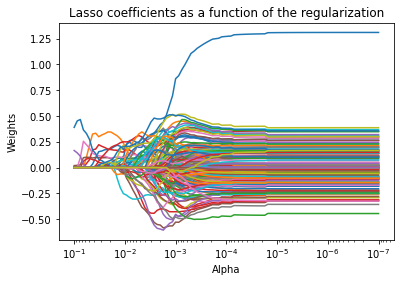

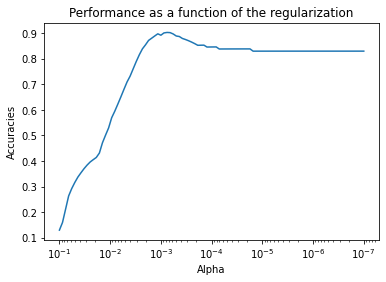

In [18]:
coefs = []
accuracies = []
times = []
n_alphas = 100
alphas = np.logspace(-7, -1, n_alphas)

for a in alphas:
    # Fit classifier
    clf = Lasso(alpha=a, fit_intercept=False,tol=0.044, random_state=RAND_STATE) # tol set to avoid warnings
    clf.fit(X_train_scaled, y_train_bin) 
    y_pred = clf.predict(X_test_scaled)
    
    # Append statistics
    accuracy = clf.score(X_train_scaled,y_train_bin)
    accuracies.append(accuracy)
    coefs.append(clf.coef_)


# Weights
plt.figure()
ax = plt.gca()
ax.plot(alphas, np.squeeze(coefs))
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('Alpha')
plt.ylabel('Weights')
plt.title('Lasso coefficients as a function of the regularization')
plt.axis('tight')
# plt.savefig(fig_dir + 'weights_lasso.png') # Comment when using google colab

# Performance
plt.figure()
ax = plt.gca()
ax.plot(alphas, accuracies)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('Alpha')
plt.ylabel('Accuracies')
plt.title('Performance as a function of the regularization')
plt.axis('tight')
# plt.savefig(fig_dir + 'performance_lasso.png') # Comment when using google colab

#### Select features

In [19]:
selector = SelectFromModel(estimator=Lasso(alpha=10**(-6), tol=0.002248888888888889, random_state=RAND_STATE), threshold='median')
selector.fit(X_train_scaled, y_train_bin)
n_original = X_train_scaled.shape[1]
X_train_fs = selector.transform(X_train_scaled)
X_test_fs = selector.transform(X_test_scaled)
n_selected = X_train_fs.shape[1]
print(f"Selected {n_selected} from {n_original} features.")

Selected 80 from 159 features.


## PCA

In [20]:
N_COMP = .9 # Capture components at 90% of the variance
pca = PCA(n_components=N_COMP, random_state=RAND_STATE)
pca.fit(X_train_fs)
X_train_pca = pca.transform(X_train_fs)
X_test_pca = pca.transform(X_test_fs)

print(f'Number of components extracted from the PCA: {X_test_pca.shape[1]}')

Number of components extracted from the PCA: 25


# Classifier

### Support Vector Machine

Best classifier: C=0.91
Best classifier: C=0.48000000000000004
Best classifier: C=0.48000000000000004
Best classifier: C=0.45
Best classifier: C=0.91
SVC results details 
        Set       
count  Train         5.000000
       Validation    5.000000
mean   Train         0.943330
       Validation    0.831914
std    Train         0.015874
       Validation    0.094842
min    Train         0.930502
       Validation    0.703704
25%    Train         0.932046
       Validation    0.790123
50%    Train         0.937500
       Validation    0.814815
75%    Train         0.947490
       Validation    0.925000
max    Train         0.969112
       Validation    0.925926
dtype: float64
The optimal C=0.6460000000000001
        AUC     n         Set     C
0  0.969112  0.91       Train   NaN
1  0.790123   NaN  Validation  0.91
2  0.932046  0.48       Train   NaN
3  0.703704   NaN  Validation  0.48
4  0.930502  0.48       Train   NaN
5  0.925926   NaN  Validation  0.48
6  0.947490  0.45       Train 

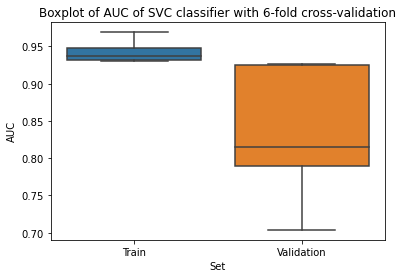

In [21]:
# Create a 6 fold stratified CV iterator
cv_6fold = StratifiedKFold(n_splits=5)
results = []
best_cls = []
y_train_a = y_train.to_numpy()

# Loop over the folds
for train_opt_index, validation_index in cv_6fold.split(X_train_pca,y_train_a):
    # Split the data properly
    X_train_opt = X_train_pca[train_opt_index]
    y_train_opt = y_train_a[train_opt_index]
    
    X_validation = X_train_pca[validation_index]
    y_validation = y_train_a[validation_index]
    
    # Create a grid search to find the optimal k using a gridsearch and 3-fold cross validation
    # Same as above
    parameters = {
        'C':list(np.linspace(0.01,1,100)),
    }
    svm_clf = SVC(kernel = 'linear', probability=True, random_state=RAND_STATE)
    cv_3fold = StratifiedKFold(n_splits=3)
    grid_search = GridSearchCV(svm_clf, parameters, cv=cv_3fold, scoring='roc_auc')
    grid_search.fit(X_train_opt, y_train_opt)
    
    # Get resulting classifier
    clf = grid_search.best_estimator_
    print(f'Best classifier: C={clf.C}')
    best_cls.append(clf.C)
    
    # Test the classifier on the train_opt data
    probabilities_train_opt = clf.predict_proba(X_train_opt)
    scores_train_opt = probabilities_train_opt[:, 1]
    
    # Get the auc
    auc_train_opt = metrics.roc_auc_score(y_train_opt, scores_train_opt)
    results.append({
        'AUC': auc_train_opt,
        'n': clf.C,
        'Set': 'Train'
    })

    # Test the classifier on the test data
    probabilities = clf.predict_proba(X_validation)
    scores = probabilities[:, 1]
    
    # Get the auc
    auc = metrics.roc_auc_score(y_validation, scores)
    results.append({
        'AUC': auc,
        'C': clf.C,
        'Set': 'Validation'
    })
    
# Create results dataframe and plot it
results = pd.DataFrame(results)
boxplot = seaborn.boxplot(y='AUC', x='Set', data=results)
boxplot.set(title='Boxplot of AUC of SVC classifier with 6-fold cross-validation')
fig = boxplot.get_figure()
# fig.savefig(fig_dir + 'boxplot_SVC.png') # Comment when using google colab
print('SVC results details \n',results.groupby("Set").AUC.describe().unstack())
optimal_c = float(np.mean(best_cls))
print(f"The optimal C={optimal_c}")
print(results)

#### Replication experiment using test set to analyse generalization

In [7]:
# Use the optimal parameters without any tuning to validate the optimal classifier
clf = SVC(kernel = 'linear', probability=True, C=optimal_c, random_state=RAND_STATE)
# Fit on the entire dataset
clf.fit(X_train_pca, y_train)

# Test the classifier on the indepedent test data
probabilities_train = clf.predict_proba(X_train_pca)
probabilities_test = clf.predict_proba(X_test_pca)
scores_train = probabilities_train[:, 1]
scores_test = probabilities_test[:, 1]

# Get the auc, sensitivity and specificity
auc_svc_train = metrics.roc_auc_score(y_train, scores_train)
auc_svc_test = metrics.roc_auc_score(y_test, scores_test)
tn, fp, fn, tp = metrics.confusion_matrix(y_test, clf.predict(X_test_pca)).ravel()
specificity = tn / (tn+fp)
sensitivity = tp/(tp+fn)
print(f'The AUC on the test set is {auc_svc_test} using a {round(optimal_c, 2)} Slack')
print('sensitivity',sensitivity)
print('specificity', specificity)

# Plot ROC curve
plot_roc(probabilities_test,y_test_bin, fig_dir+ 'ROC_kNN.png', f'ROC curve of SVC classifier using a {round(optimal_c,2)} Slack')

NameError: name 'optimal_c' is not defined

#### KNN

Best classifier: n=14
Best classifier: n=3
Best classifier: n=4
Best classifier: n=5
Best classifier: n=8
Best classifier: n=5
kNN results details 
        Set       
count  Train         6.000000
       Validation    6.000000
mean   Train         1.000000
       Validation    0.816964
std    Train         0.000000
       Validation    0.139326
min    Train         1.000000
       Validation    0.616071
25%    Train         1.000000
       Validation    0.718750
50%    Train         1.000000
       Validation    0.870536
75%    Train         1.000000
       Validation    0.915179
max    Train         1.000000
       Validation    0.946429
dtype: float64
The optimal k=6
         AUC   k         Set
0   1.000000  14       Train
1   0.875000  14  Validation
2   1.000000   3       Train
3   0.616071   3  Validation
4   1.000000   4       Train
5   0.928571   4  Validation
6   1.000000   5       Train
7   0.946429   5  Validation
8   1.000000   8       Train
9   0.669643   8  Validation
10 

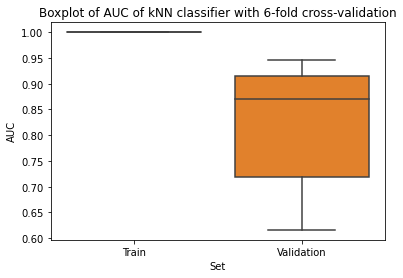

In [13]:
# Create a 6 fold stratified CV iterator
cv_6fold = StratifiedKFold(n_splits=6)
results = []
best_cls = []
y_train_a = y_train.to_numpy()

# Loop over the folds
for train_opt_index, validation_index in cv_6fold.split(X_train_pca,y_train_a):
    # Split the data properly
    X_train_opt = X_train_pca[train_opt_index]
    y_train_opt = y_train_a[train_opt_index]
    
    X_validation = X_train_pca[validation_index]
    y_validation = y_train_a[validation_index]
    
    # Create a grid search to find the optimal k using a gridsearch and 3-fold cross validation
    # Same as above
    parameters = {
        'n_neighbors': list(range(1,31)),
    }
    knn_clf = KNeighborsClassifier(weights='distance')
    cv_3fold = StratifiedKFold(n_splits=3)
    grid_search = GridSearchCV(knn_clf, parameters, cv=cv_3fold, scoring='roc_auc')
    grid_search.fit(X_train_opt, y_train_opt)
    
    # Get resulting classifier
    clf = grid_search.best_estimator_
    print(f'Best classifier: k={clf.n_neighbors}')
    best_cls.append(clf.n_neighbors)
    
    # Test the classifier on the train_opt data
    probabilities_train_opt = clf.predict_proba(X_train_opt)
    scores_train_opt = probabilities_train_opt[:, 1]
    
    # Get the auc
    auc_train_opt = metrics.roc_auc_score(y_train_opt, scores_train_opt)
    results.append({
        'AUC': auc_train_opt,
        'k': clf.n_neighbors,
        'Set': 'Train'
    })

    # Test the classifier on the test data
    probabilities = clf.predict_proba(X_validation)
    scores = probabilities[:, 1]
    
    # Get the auc
    auc = metrics.roc_auc_score(y_validation, scores)
    results.append({
        'AUC': auc,
        'k': clf.n_neighbors,
        'Set': 'Validation'
    })
    
# Create results dataframe and plot it
results = pd.DataFrame(results)
boxplot = seaborn.boxplot(y='AUC', x='Set', data=results)
boxplot.set(title='Boxplot of AUC of kNN classifier with 6-fold cross-validation')
fig = boxplot.get_figure()
# fig.savefig(fig_dir + 'boxplot_KNN.png') # Comment when using google colab
print('kNN results details \n',results.groupby("Set").AUC.describe().unstack()) 

optimal_n = int(np.mean(best_cls))
print(f"The optimal k={optimal_n}")
print(results)

#### Replication experiment using test set to analyse generalization

The AUC on the test set is 0.7613636363636364 using a 6-NN
sensitivity 0.7272727272727273
specificity 0.5833333333333334


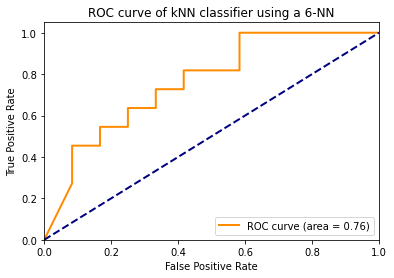

In [14]:
# Use the optimal parameters without any tuning to validate the optimal classifier
clf = KNeighborsClassifier(weights='distance', n_neighbors=optimal_n)
# Fit on the entire dataset
clf.fit(X_train_pca, y_train)

# Test the classifier on the indepedent test data
probabilities_train = clf.predict_proba(X_train_pca)
probabilities_test = clf.predict_proba(X_test_pca)
scores_train = probabilities_train[:, 1]
scores_test = probabilities_test[:, 1]

# Get the auc
auc_knn_train = metrics.roc_auc_score(y_train, scores_train)
auc_knn_test = metrics.roc_auc_score(y_test, scores_test)
print(f'The AUC on the test set is {auc_knn_test} using a {optimal_n}-NN')

plot_roc(probabilities_test,y_test_bin, fig_dir + 'ROC_kNN.png', f'ROC curve of kNN classifier using a {optimal_n}-NN')


tn, fp, fn, tp = metrics.confusion_matrix(y_test, clf.predict(X_test_pca)).ravel()
specificity = tn / (tn+fp)
sensitivity = tp/(tp+fn)
print('sensitivity',sensitivity)
print('specificity', specificity)

## Evaluation setup

### Evaluation run

In [15]:
score_train_svc =[]
score_test_svc = []
sensitivity_svc = []
specificity_svc = []
score_train_knn =[]
score_test_knn = []
sensitivity_knn = []
specificity_knn = []
results_ev = []

for i in range(100): # Repating the algorithm 100 times and saving the results to results_ev
    auc_svc_train_R, auc_svc_test_R,sensitivity_svc_R, specificity_svc_R, auc_knn_train_R, auc_knn_test_R, sensitivity_knn_R, specificity_knn_R = eval_func(features,label)
    score_train_svc.append(auc_svc_train_R)
    score_test_svc.append(auc_svc_test_R)
    sensitivity_svc.append(sensitivity_svc_R)
    specificity_svc.append(specificity_svc_R)
    score_train_knn.append(auc_knn_train_R)
    score_test_knn.append(auc_knn_test_R)
    sensitivity_knn.append(sensitivity_knn_R)
    specificity_knn.append(specificity_knn_R)

    results_ev.append({
        'auc' : auc_svc_test_R,
        'sensitivity' : sensitivity_svc_R,
        'specificity' : specificity_svc_R,
        'clf' : 'SVC'
    })
    
    results_ev.append({
        'auc' : auc_knn_test_R,
        'sensitivity' : sensitivity_knn_R,
        'specificity' : specificity_knn_R,
        'clf' : 'kNN'
    })

### Plotting boxplot

AUC details 
        clf
count  SVC    100.000000
       kNN    100.000000
mean   SVC      0.813523
       kNN      0.793409
std    SVC      0.084739
       kNN      0.093531
min    SVC      0.507576
       kNN      0.492424
25%    SVC      0.763258
       kNN      0.734848
50%    SVC      0.818182
       kNN      0.801136
75%    SVC      0.873106
       kNN      0.863636
max    SVC      0.977273
       kNN      0.962121
dtype: float64
Sensitivity details 
        clf
count  SVC    100.000000
       kNN    100.000000
mean   SVC      0.708182
       kNN      0.747273
std    SVC      0.163593
       kNN      0.175548
min    SVC      0.090909
       kNN      0.000000
25%    SVC      0.636364
       kNN      0.636364
50%    SVC      0.727273
       kNN      0.818182
75%    SVC      0.818182
       kNN      0.909091
max    SVC      1.000000
       kNN      1.000000
dtype: float64
Specificity details 
        clf
count  SVC    100.000000
       kNN    100.000000
mean   SVC      0.747500
    

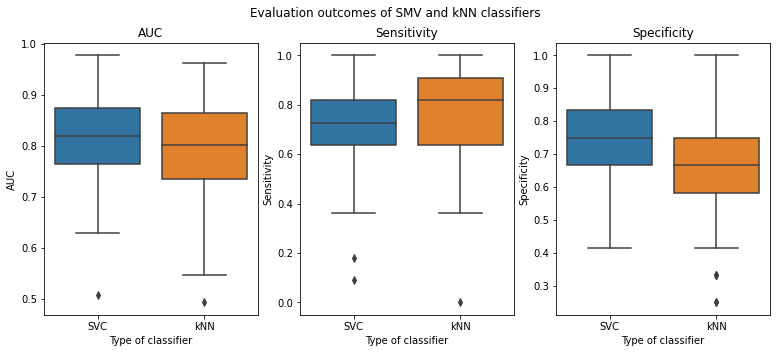

In [18]:
results_ev = pd.DataFrame(results_ev)
print('AUC details \n', results_ev.groupby("clf").auc.describe().unstack())
print('Sensitivity details \n', results_ev.groupby("clf").sensitivity.describe().unstack())
print('Specificity details \n', results_ev.groupby("clf").specificity.describe().unstack())

# Making boxplots
fig, axes = plt.subplots(1, 3, figsize=(13,5))
fig.suptitle('Evaluation outcomes of SMV and kNN classifiers')
seaborn.boxplot(ax = axes[0], y='auc', x='clf', data=results_ev) 
seaborn.boxplot(ax = axes[1],y='sensitivity', x='clf', data=results_ev)
seaborn.boxplot(ax = axes[2],y='specificity', x='clf', data=results_ev)
axes[0].set_title('AUC')
axes[0].set_ylabel('AUC')
axes[1].set_title('Sensitivity')
axes[1].set_ylabel('Sensitivity')
axes[2].set_title('Specificity')
axes[2].set_ylabel('Specificity')

axes[0].set_xlabel('Type of classifier')
axes[1].set_xlabel('Type of classifier')
axes[2].set_xlabel('Type of classifier')

# fig.savefig(fig_dir+ 'evaluation_outcomes.png') # Comment when using google colab

### T-test

In [23]:
print('AUC:         ',ttest_ind(score_train_svc, score_train_knn))
print('Sensitivity: ',ttest_ind(sensitivity_svc, sensitivity_knn))
print('Specificity: ',ttest_ind(specificity_svc, specificity_knn))

AUC:          Ttest_indResult(statistic=-37.6460001642558, pvalue=3.43585836858056e-92)
Sensitivity:  Ttest_indResult(statistic=-1.6290716964711982, pvalue=0.10488779919379873)
Specificity:  Ttest_indResult(statistic=5.103871050434764, pvalue=7.779438105911966e-07)
